### Import all the Dependencies

In [8]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from pathlib import Path

### Set all constants required

In [9]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = Path(r"C:\Projects\PotatoDiseaseClassification\Training\PlantVillage")
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

## Initializing, Exploring & Partioning the Dataset

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1  # Ensure valid splits

    ds_size = ds.cardinality().numpy()  # Get total number of samples

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  # Shuffle dataset before splitting

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

### Reading and Partitioning the Dataset
We create a Tensorflow Dataset Object and directly read it from the directory using `image_dataset_from_directory` and then split it using the function we created above

In [11]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

Found 2152 files belonging to 3 classes.


### Check if train_ds is defined

In [12]:
print(f"Train dataset: {train_ds.cardinality().numpy()} samples")

Train dataset: 54 samples


### Check the Accuracy of directory path

In [13]:
from pathlib import Path

data_dir = Path(r"C:\Projects\PotatoDiseaseClassification\Training\PlantVillage")

if data_dir.exists():
    print("Path exists:", data_dir.resolve())
else:
    print("Path does NOT exist. Check the directory.")


Path exists: C:\Projects\PotatoDiseaseClassification\Training\PlantVillage


### Checking the Available Classes

In [14]:
class_names = ds.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


### Displaying Some Sample Images

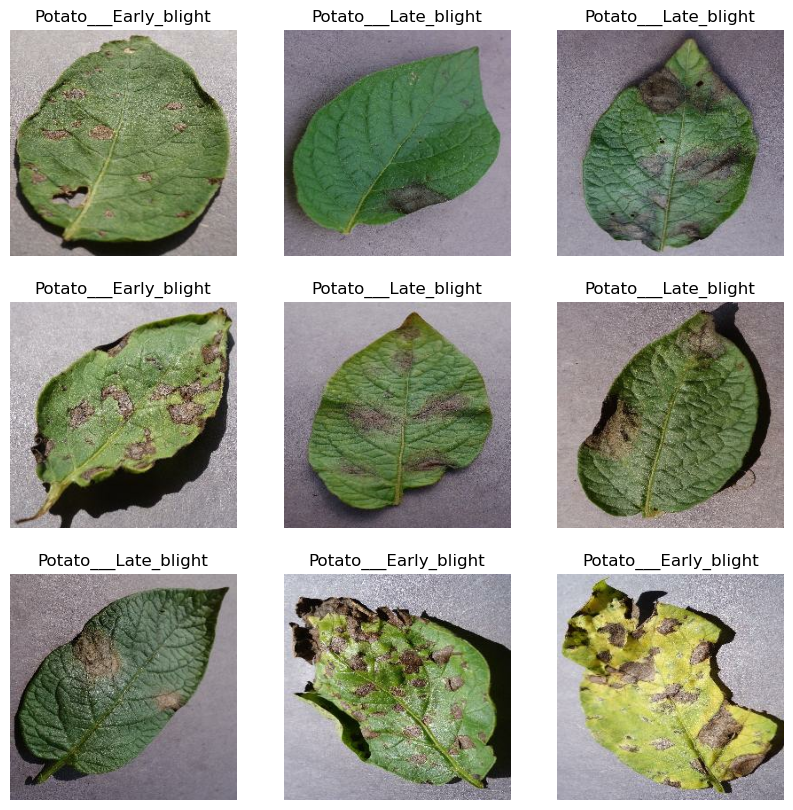

In [16]:
# ✅ Plot images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch
    for i in range(min(9, images.shape[0])):  # Ensure at least 9 images exist
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])  # Convert label tensor to integer
        plt.axis("off")
plt.show()

### Checking Batch Size

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### Cache, Shuffle, and Prefetch the Dataset

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Checking what is the expected dimension order for channel

In [21]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.
We might encounter warning when we run the model architecure. These warnings are coming from TensorFlow and are related to TensorFlow's Graph Execution and XLA (Accelerated Linear Algebra) optimizations.
#### What Does This Mean?
"Using a while_loop for converting..." → TensorFlow is internally converting some operations (like RngReadAndSkip, Bitcast, and ImageProjectiveTransformV3) into a loop because it does not have a registered converter for them in the compiled graph.
Possible Cause: This is common when using data augmentation or random transformations inside a tf.data.Dataset pipeline.
##### This is not an error, so your code should still run fine. But if you want to reduce the warnings, try these solutions:
1. Upgrade TensorFlow
2. Disable TensorFlow Warnings
3. Disable XLA Compilation
4.  Check Your Data Augmentation Pipeline

In [22]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

### Model Summary

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training the Network

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 177s 3s/step - loss: 0.8996 - accuracy: 0.4806 - val_loss: 0.8652 - val_accuracy: 0.4635
Epoch 2/50
54/54 [==============================] - 143s 3s/step - loss: 0.7565 - accuracy: 0.6408 - val_loss: 1.0727 - val_accuracy: 0.7135
Epoch 3/50
54/54 [==============================] - 151s 3s/step - loss: 0.5604 - accuracy: 0.7700 - val_loss: 0.6486 - val_accuracy: 0.7135
Epoch 4/50
54/54 [==============================] - 152s 3s/step - loss: 0.3387 - accuracy: 0.8592 - val_loss: 0.3499 - val_accuracy: 0.8229
Epoch 5/50
54/54 [==============================] - 120s 2s/step - loss: 0.2667 - accuracy: 0.8938 - val_loss: 0.3714 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 117s 2s/step - loss: 0.2266 - accuracy: 0.9102 - val_loss: 0.2820 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 116s 2s/step - loss: 0.1844 - accuracy: 0.9319 - val_loss: 0.2522 - val_accuracy: 0.8854
Epoch 8/50
54

### Testing the Model

In [26]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 15s 740ms/step - loss: 0.1363 - accuracy: 0.9570
Test Accuracy: 95.7%


### Plotting the Accuracy and Loss Curves

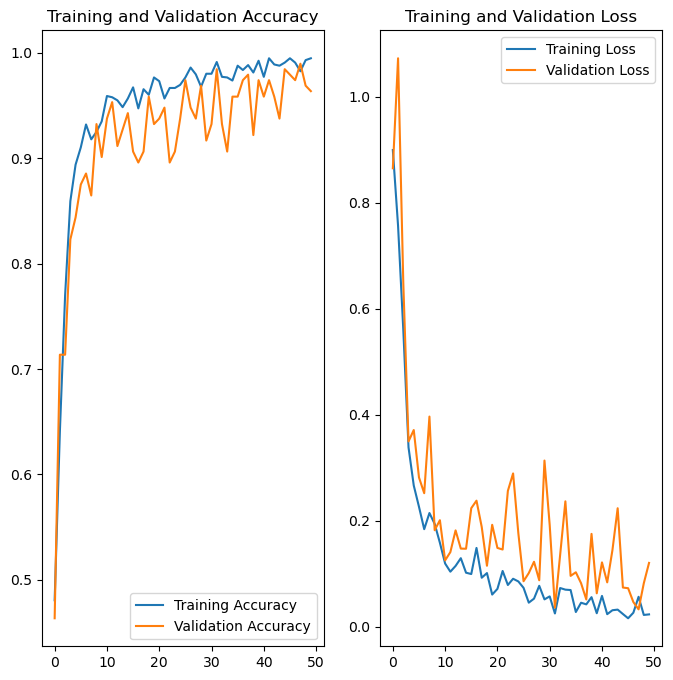

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Saving the Model
We append the model to the list of models as a new version

In [28]:
import os
model_version = max([int(i) for i in (os.listdir("../models")+[0])]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


### Function for Inference

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Plotting the Inference Data

1/1 [==============================] - 0s 65ms/step


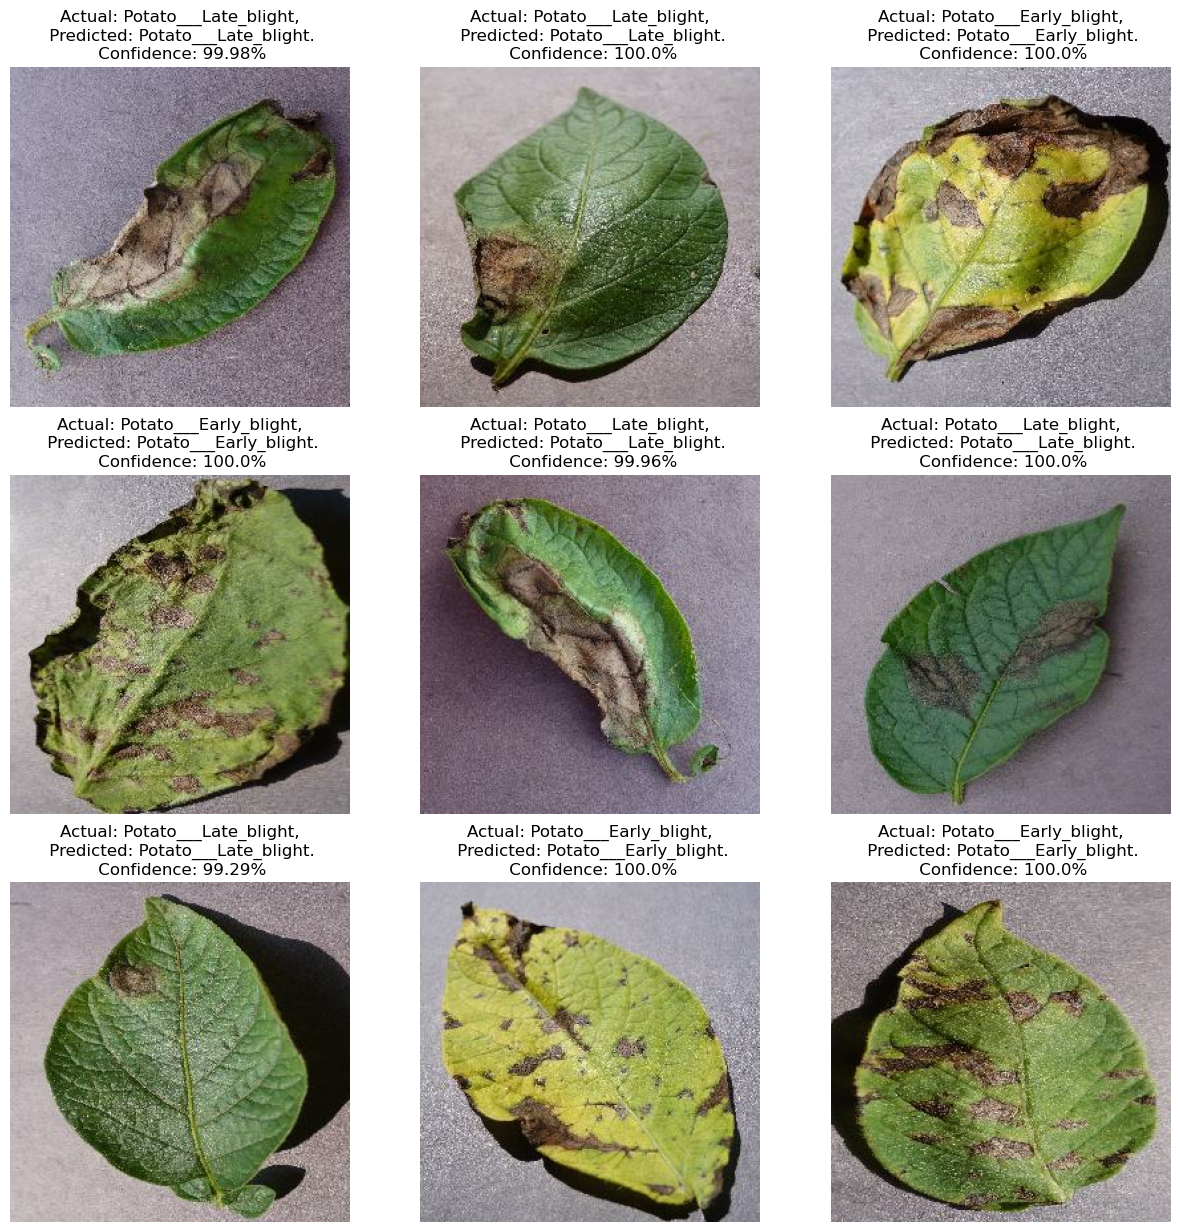

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")